In [1]:
from platform import python_version
print(python_version())

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import glob
import cv2
print(tf.__version__)

2.3.0


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
train_images = []
for i in range(0,60000):
    n= cv2.imread("./train_LbELtWX/train/"+ str(i+1) + ".png")
    train_images.append(n)   
train_images = np.asarray(train_images)
train_labels = pd.read_csv("./train_LbELtWX/train.csv", usecols=['label']).values.flatten() 
    
test_images = []
for i in range(60000,70000):
    n= cv2.imread("./test_ScVgIM0/test/"+ str(i+1) + ".png")
    test_images.append(n)
test_images = np.asarray(test_images)

train_images = (train_images)/ 255.0
test_images = (test_images)/ 255.0

train_images = train_images[:,:,:,0].reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images[:,:,:,0].reshape((test_images.shape[0], 28, 28, 1))

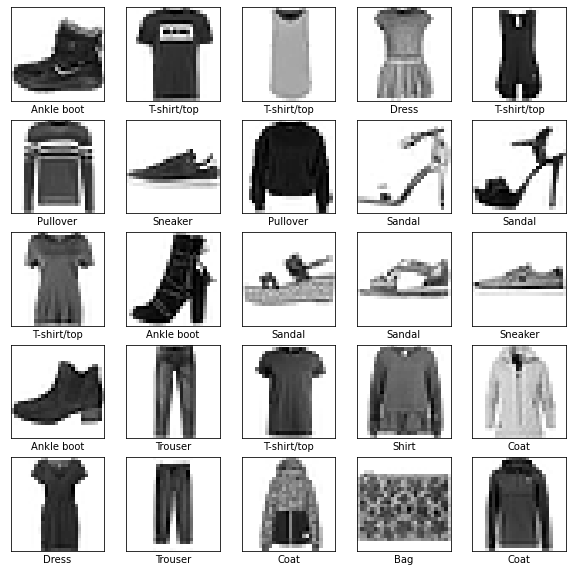

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [12]:
def squeeze_excite_block(filters,input):                      
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Reshape((1, filters))(se) 
    se = tf.keras.layers.Dense(filters//16, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    se = tf.keras.layers.multiply([input, se])
    return se


model_input = tf.keras.Input(shape=(28,28,1), name='img')
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(model_input)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = squeeze_excite_block(64,x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = squeeze_excite_block(64,x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = squeeze_excite_block(128,x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

model_output = tf.keras.layers.Dense(10)(x)

model = tf.keras.Model(model_input, model_output, name="Classifical_model")

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

Model: "Classifical_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 64)   640         img[0][0]                        
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 64)   36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 28, 28, 64)   256         conv2d_7[0][0]                   
__________________________________________________________________________________

In [18]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
                                            monitor='val_accuracy', min_delta=0.0000001, 
                                            patience=10, verbose=2, mode='auto')

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor='val_loss', factor=0.1, 
                                            patience=5, min_lr=0.0001)

filepath="weights.best.hdf5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(train_images, train_labels, epochs=50, validation_split=0.12, 
                    callbacks=[earlystop_callback, reduce_lr_callback, checkpoint_callback],
                    verbose=2)

Epoch 1/50
1500/1500 - 20s - loss: 0.1298 - accuracy: 0.9539 - val_loss: 0.2155 - val_accuracy: 0.9302
Epoch 2/50
1500/1500 - 20s - loss: 0.1237 - accuracy: 0.9547 - val_loss: 0.2000 - val_accuracy: 0.9307
Epoch 3/50
1500/1500 - 20s - loss: 0.1177 - accuracy: 0.9562 - val_loss: 0.2056 - val_accuracy: 0.9323
Epoch 4/50
1500/1500 - 19s - loss: 0.1141 - accuracy: 0.9596 - val_loss: 0.2130 - val_accuracy: 0.9352
Epoch 5/50
1500/1500 - 20s - loss: 0.1066 - accuracy: 0.9607 - val_loss: 0.2171 - val_accuracy: 0.9328
Epoch 6/50
1500/1500 - 20s - loss: 0.1029 - accuracy: 0.9622 - val_loss: 0.2151 - val_accuracy: 0.9391
Epoch 7/50
1500/1500 - 20s - loss: 0.0994 - accuracy: 0.9647 - val_loss: 0.2094 - val_accuracy: 0.9379
Epoch 8/50
1500/1500 - 19s - loss: 0.0951 - accuracy: 0.9657 - val_loss: 0.2097 - val_accuracy: 0.9383
Epoch 9/50
1500/1500 - 19s - loss: 0.0882 - accuracy: 0.9680 - val_loss: 0.2141 - val_accuracy: 0.9360
Epoch 10/50
1500/1500 - 20s - loss: 0.0608 - accuracy: 0.9775 - val_loss:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


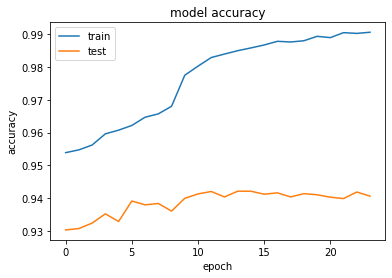

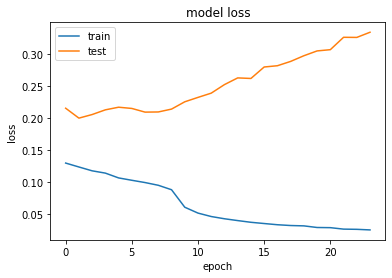

In [19]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
model.load_weights("weights.best.hdf5")
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
predictions = np.argmax(model.predict(test_images), axis=-1)
predictions

array([9, 2, 1, ..., 8, 1, 5])

In [24]:
test = pd.read_csv("./test_ScVgIM0/test.csv")
test['label'] = pd.DataFrame(data=predictions.flatten())
test.to_csv("./Results/test_final.csv", index=False)
test

,id,label
0,60001,9
1,60002,2
2,60003,1
3,60004,1
4,60005,6
...,...,...
9995,69996,9
9996,69997,1
9997,69998,8
9998,69999,1
